In [1]:
import numpy as np
from transformers import TrainingArguments, Trainer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
import torch
from sklearn.utils.class_weight import compute_class_weight

In [2]:
df = pd.read_csv("final_preprocessing.csv")
y_train = df['label'].values
classes = np.unique(y_train)
classes

array([0, 1, 2])

In [7]:
#!pip install googletrans==4.0.0-rc1

import pandas as pd
from googletrans import Translator
from tqdm import tqdm

# Load original dataset
df = pd.read_csv("final_preprocessing.csv")

# Detect the correct text column (same logic as before)
text_column = None
for col in ["normalization", "cleaned_comment", "comment"]:
    if col in df.columns:
        text_column = col
        break

if text_column is None:
    raise ValueError("No valid text column found for translation!")

print(f"Translating column: {text_column}")

# Ensure column is string
df[text_column] = df[text_column].astype(str)

# Translator object
translator = Translator()

translated_texts = []

# Translate row-by-row with progress bar
for text in tqdm(df[text_column], desc="Translating to English"):
    try:
        translated = translator.translate(text, dest="en").text
        translated_texts.append(translated)
    except:
        translated_texts.append(text)  # fallback if translation fails

# Save new English column
df["text_en"] = translated_texts

# Save as new dataset
translated_path = "final_preprocessing_translated.csv"
df.to_csv(translated_path, index=False)

print(f"Translation completed! Saved to: {translated_path}")
print(df.head())


Translating column: normalization


Translating to English: 100%|██████████| 4138/4138 [14:01<00:00,  4.92it/s]

Translation completed! Saved to: final_preprocessing_translated.csv
                                             comment  \
0                 Gambar kebaretnya boongan ternyata   
1  Buat pemakai biasa sama saja iphone 16 promax,...   
2                                Case poco&quot; ??   
3  Kaum miFans dan kaum munafik iri dengki lg kum...   
4                      Saya mah nunggu S26 Ultra aja   

                                     cleaned_comment  \
0                 Gambar kebaretnya boongan ternyata   
1  Buat pemakai biasa sama saja iphone 16 promax ...   
2                                     Case pocoquot    
3  Kaum miFans dan kaum munafik iri dengki lg kum...   
4                      Saya mah nunggu S26 Ultra aja   

                                        case_folding  \
0                 gambar kebaretnya boongan ternyata   
1  buat pemakai biasa sama saja iphone 16 promax ...   
2                                     case pocoquot    
3  kaum mifans dan kaum munafik ir

In [9]:
train_df, test_df = train_test_split(df,test_size=0.2,random_state=42, stratify=df['label'])
train_df.shape, test_df.shape

((3310, 6), (828, 6))

In [10]:
labels = train_df["label"].values
class_counts = np.bincount(labels)
class_weights = len(labels) / (len(class_counts) * class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print(f"Class Counts :{class_counts}\nClass Weights:", class_weights_tensor)


Class Counts :[1233 1754  323]
Class Weights: tensor([0.8948, 0.6290, 3.4159])


In [11]:
from transformers import Trainer
from torch.nn import CrossEntropyLoss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = CrossEntropyLoss(weight=class_weights_tensor.to(logits.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [13]:
def prepare_dataset(tokenizer, train_df, test_df, max_length=128):

    # detect text column
    text_column = next(
        col for col in ["normalization", "cleaned_comment", "comment","text_en "]
        if col in train_df.columns
    )

    # ensure string
    train_df[text_column] = train_df[text_column].astype(str)
    test_df[text_column] = test_df[text_column].astype(str)

    # to Dataset
    train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
    test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))

    # tokenizing function
    def tokenize_function(example):
        return tokenizer(example[text_column],
                         padding="max_length",
                         truncation=True,
                         max_length=max_length)

    train_ds = train_ds.map(tokenize_function, batched=True)
    test_ds = test_ds.map(tokenize_function, batched=True)

    # cleanup
    cols_remove = list(set(["comment","cleaned_comment","case_folding","normalization","__index_level_0__","text_en"]) &
                       set(train_ds.column_names))

    train_ds = train_ds.remove_columns(cols_remove).rename_column("label", "labels")
    test_ds = test_ds.remove_columns(cols_remove).rename_column("label", "labels")

    train_ds.set_format("torch")
    test_ds.set_format("torch")

    return train_ds, test_ds


In [14]:
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_score": f1_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro"),
    }

In [15]:
roberta_checkpoint = "xlm-roberta-base"
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_checkpoint)
train_roberta, test_roberta = prepare_dataset(roberta_tokenizer, train_df, test_df)

r_model = AutoModelForSequenceClassification.from_pretrained(
    roberta_checkpoint,
    num_labels=len(class_counts)
)

args_roberta = TrainingArguments(
    output_dir="./roberta-model",
    learning_rate=2.1849990412013717e-05,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    seed=11,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=20,
    load_best_model_at_end=True,
    report_to="none",
    save_total_limit=2
)

trainer_roberta = Trainer(
    model=r_model,
    args=args_roberta,
    train_dataset=train_roberta,
    eval_dataset=test_roberta,
    compute_metrics=compute_metrics,
    tokenizer=roberta_tokenizer,
)

trainer_roberta.train()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/3310 [00:00<?, ? examples/s]

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2434853745.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_roberta = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Recall,Precision
1,0.810800,0.803582,0.669082,0.460727,0.483305,0.442265
2,0.693000,0.692693,0.721014,0.503234,0.534040,0.477510
3,0.627200,0.651369,0.766908,0.612296,0.603811,0.744291
4,0.509500,0.668772,0.763285,0.639007,0.624056,0.703130
5,0.395300,0.687383,0.753623,0.630682,0.620368,0.662359


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1035, training_loss=0.6734634744948235, metrics={'train_runtime': 706.9647, 'train_samples_per_second': 23.41, 'train_steps_per_second': 1.464, 'total_flos': 1088631765849600.0, 'train_loss': 0.6734634744948235, 'epoch': 5.0})

              precision    recall  f1-score   support

           0       0.73      0.82      0.77       308
           1       0.79      0.85      0.82       439
           2       0.71      0.15      0.24        81

    accuracy                           0.77       828
   macro avg       0.74      0.60      0.61       828
weighted avg       0.76      0.77      0.75       828



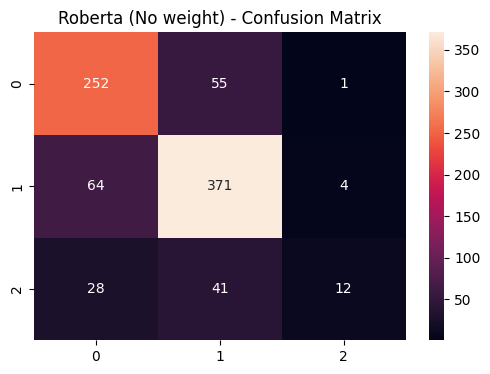

In [16]:
preds = trainer_roberta.predict(test_roberta)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Roberta (No weight) - Confusion Matrix")
plt.show()


In [17]:
weighted_roberta = AutoModelForSequenceClassification.from_pretrained(
    roberta_checkpoint,
    num_labels=len(class_counts)
)

trainer_roberta_weight = WeightedTrainer(
    model=weighted_roberta,
    args=args_roberta,
    train_dataset=train_roberta,
    eval_dataset=test_roberta,
    compute_metrics=compute_metrics,
    tokenizer=roberta_tokenizer,
)

trainer_roberta_weight.train()


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1118777776.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer_roberta_weight = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Recall,Precision
1,1.021100,1.029816,0.603865,0.475543,0.477224,0.608988
2,0.916700,0.941383,0.584541,0.508013,0.540886,0.521528
3,0.760900,0.853536,0.699275,0.625122,0.649892,0.616101
4,0.623200,0.846231,0.729469,0.654592,0.659130,0.650657
5,0.606600,0.870781,0.721014,0.660702,0.685956,0.647812


TrainOutput(global_step=1035, training_loss=0.8471872569282274, metrics={'train_runtime': 751.0725, 'train_samples_per_second': 22.035, 'train_steps_per_second': 1.378, 'total_flos': 1088631765849600.0, 'train_loss': 0.8471872569282274, 'epoch': 5.0})

              precision    recall  f1-score   support

           0       0.72      0.73      0.72       308
           1       0.80      0.77      0.79       439
           2       0.44      0.47      0.45        81

    accuracy                           0.73       828
   macro avg       0.65      0.66      0.65       828
weighted avg       0.73      0.73      0.73       828



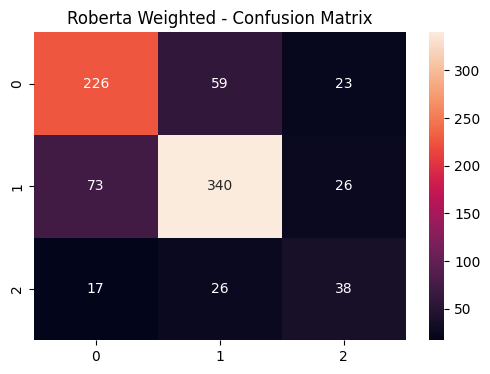

In [19]:
preds = trainer_roberta_weight.predict(test_roberta)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Roberta Weighted - Confusion Matrix")
plt.show()


In [ ]:
indo_checkpoint = "indobenchmark/indobert-base-p1"
indo_tokenizer = AutoTokenizer.from_pretrained(indo_checkpoint)
train_indo, test_indo = prepare_dataset(indo_tokenizer, train_df, test_df)

indo_model = AutoModelForSequenceClassification.from_pretrained(
    indo_checkpoint,
    num_labels=len(class_counts)
)

args_indo = TrainingArguments(
    output_dir="./indobert_standard",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=20,
    report_to="none",
    save_total_limit=2
)

trainer_indo = Trainer(
    model=indo_model,
    args=args_indo,
    train_dataset=train_indo,
    eval_dataset=test_indo,
    compute_metrics=compute_metrics,
    tokenizer=indo_tokenizer,
)

trainer_indo.train()


Map:   0%|          | 0/3310 [00:00<?, ? examples/s]

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-691494071.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_indo = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Recall,Precision
1,0.702300,0.761738,0.665459,0.490964,0.484945,0.716959
2,0.617200,0.837893,0.728261,0.616715,0.613016,0.694454
3,0.177300,1.145525,0.724638,0.634415,0.629372,0.640616


TrainOutput(global_step=1242, training_loss=0.4787114400337128, metrics={'train_runtime': 372.5162, 'train_samples_per_second': 26.657, 'train_steps_per_second': 3.334, 'total_flos': 653179059509760.0, 'train_loss': 0.4787114400337128, 'epoch': 3.0})

IndoBERT (No Weight) Classification Report
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       308
           1       0.77      0.80      0.78       439
           2       0.42      0.38      0.40        81

    accuracy                           0.72       828
   macro avg       0.64      0.63      0.63       828
weighted avg       0.72      0.72      0.72       828



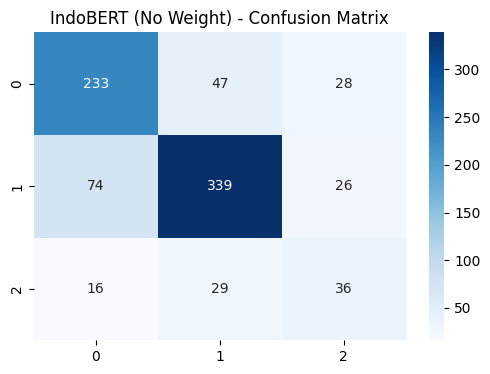

In [ ]:
preds = trainer_indo.predict(test_indo)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print("IndoBERT (No Weight) Classification Report")
print(classification_report(y_true, y_pred))

ib_cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("IndoBERT (No Weight) - Confusion Matrix")
plt.show()


In [ ]:
indo_checkpoint = "indobenchmark/indobert-base-p1"
indo_tokenizer = AutoTokenizer.from_pretrained(indo_checkpoint)
train_indo, test_indo = prepare_dataset(indo_tokenizer, train_df, test_df)

indo_model = AutoModelForSequenceClassification.from_pretrained(
    indo_checkpoint,
    num_labels=len(class_counts)
)

weighted_indo_model = AutoModelForSequenceClassification.from_pretrained(
    indo_checkpoint,
    num_labels=len(class_counts)
)

trainer_indo_weight = WeightedTrainer(
    model=weighted_indo_model,
    args=args_indo,
    train_dataset=train_indo,
    eval_dataset=test_indo,
    compute_metrics=compute_metrics,
    tokenizer=indo_tokenizer,
)

trainer_indo_weight.train()


Map:   0%|          | 0/3310 [00:00<?, ? examples/s]

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4214822693.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer_indo_weight = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Recall,Precision
1,0.900900,0.833798,0.724638,0.647141,0.648918,0.661614
2,0.644500,0.836149,0.735507,0.654650,0.661648,0.666787
3,0.186300,1.242761,0.734300,0.651158,0.657716,0.646077


TrainOutput(global_step=1242, training_loss=0.6630357498851951, metrics={'train_runtime': 400.0151, 'train_samples_per_second': 24.824, 'train_steps_per_second': 3.105, 'total_flos': 653179059509760.0, 'train_loss': 0.6630357498851951, 'epoch': 3.0})

IndoBERT (Weighted) Classification Report
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       308
           1       0.82      0.77      0.79       439
           2       0.40      0.44      0.42        81

    accuracy                           0.73       828
   macro avg       0.65      0.66      0.65       828
weighted avg       0.74      0.73      0.74       828



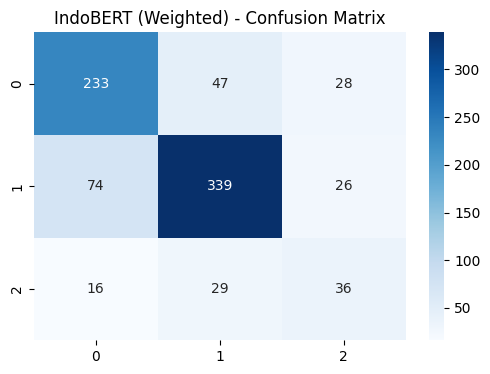

In [ ]:
preds = trainer_indo_weight.predict(test_indo)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

print("IndoBERT (Weighted) Classification Report")
print(classification_report(y_true, y_pred))

ibw_cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("IndoBERT (Weighted) - Confusion Matrix")
plt.show()


# Comparison Between Models

In [24]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

preds = trainer_roberta.predict(test_roberta)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

precision_nw, recall_nw, f1_nw, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
accuracy_nw = accuracy_score(y_true, y_pred)

In [22]:
preds = trainer_roberta_weight.predict(test_roberta)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
accuracy_w = accuracy_score(y_true, y_pred)

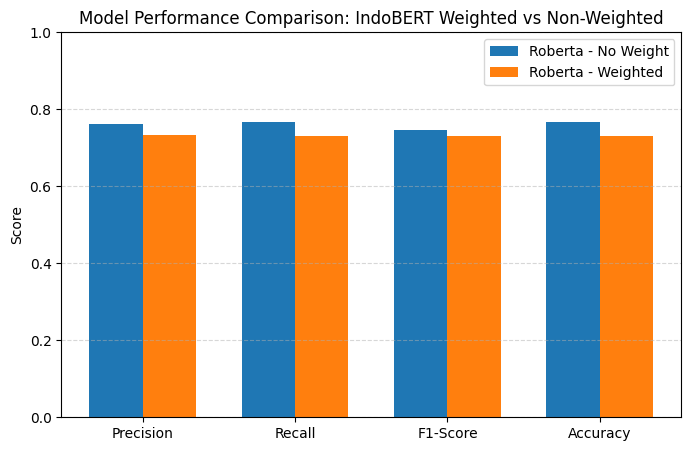

In [25]:
metrics = ["Precision", "Recall", "F1-Score", "Accuracy"]
scores_nw = [precision_nw, recall_nw, f1_nw, accuracy_nw]
scores_w = [precision_w, recall_w, f1_w, accuracy_w]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, scores_nw, width, label="Roberta - No Weight")
plt.bar(x + width/2, scores_w, width, label="Roberta - Weighted")

plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Model Performance Comparison: IndoBERT Weighted vs Non-Weighted")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()